# ◇ 라이브러리 설정 numpy, maplotlib

In [259]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

# ◇ Fashion-MNIST 데이터 가져오기
- ### https://github.com/zalandoresearch/fashion-mnist/tree/master/data/fashion
- ### 깃허브에서 받은 4개의 .gz 데이터 파일을 가져오기 위해 gzip라이브러리를 import
- ### 데이터를 불러오는 함수를 정의하고, 경로를 설정
- ### 실제 가져오는 코드는 아래쪽 학습하기 전에 가져옴

In [260]:
import gzip
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        # 파일에서 데이터를 읽어 들입니다.
        data = f.read()
        # 이미지는 16바이트 헤더를 가지고 있으므로, 이를 건너뛰고 나머지 데이터를 읽어옵니다.
        images = np.frombuffer(data, np.uint8, offset=16)
        # 이미지를 (num_samples, 28, 28) 형식으로 재구성합니다.
        images = images.reshape(-1, 1, 28, 28)
    return images

def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        # 파일에서 데이터를 읽어 들입니다.
        data = f.read()
        # 레이블은 8바이트 헤더를 가지고 있으므로, 이를 건너뛰고 나머지 데이터를 읽어옵니다.
        labels = np.frombuffer(data, np.uint8, offset=8)
    return labels

# 파일 경로를 설정합니다.
train_images_path = 'Fashion-MNIST/train-images-idx3-ubyte.gz'
train_labels_path = 'Fashion-MNIST/train-labels-idx1-ubyte.gz'
test_images_path = 'Fashion-MNIST/t10k-images-idx3-ubyte.gz'
test_labels_path = 'Fashion-MNIST/t10k-labels-idx1-ubyte.gz'

# ◇ 계층 클래스 Affine
#### Affine클래스는 해당 부분을 저장
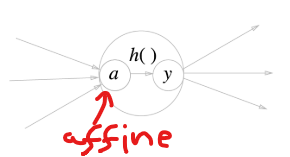

In [261]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        #print(self.x.shape, self.W.shape)
        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx

# ◇ 활성화 함수 Relu, softmax
# ◇ 손실 함수 cross_entropy_error (교차 엔트로피 오차)
# ◇ 수치미분-기울기 numerical_gradient
# ◇ 출력층 클래스 -> 소프트맥스, 손실 함수 값을 계산-저장 SoftmaxWithLoss

----
#### class Relu는 해당 부분을 저장
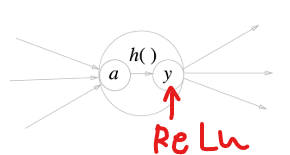

In [262]:
# Relu 활성화 함수 순전파, 역전파를 저장하는 클래스
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

In [263]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

In [264]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [265]:
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        it.iternext()   
        
    return grad

In [266]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

# ◇ 최적화 함수 SGD, Momentum, AdaGrad

In [267]:
class SGD:
    def __init__(self, Ir=0.01):
        self.Ir =Ir

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.Ir * grads[key]

In [268]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

In [269]:
class AdaGrad:
    def __init__ (self, Ir=0.01):
        self.Ir =Ir
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys() :
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.Ir * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


# ◇  배치 정규화 클래스

In [270]:
class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma=1, beta=0, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원  

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx

# ◇ CNN im2col, col2im함수

In [271]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    
    # 행렬의 차원을 가져옴
    N, C, H, W = input_data.shape
    
    # 그 행렬과 필터를 계산했을 때 나오는 사이즈를 계산
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    
    # 패딩 적용
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    
    # 출력 행렬 사이즈만큼 0으로 초기화
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    
    for y in range(filter_h):
        # 현재 y번째에서 y(열)의 범위 지정
        y_max = y + stride*out_h
        for x in range(filter_w):
            # 현재 x번째에서 x(행)의 범위 지정
            x_max = x + stride*out_w
            
            # 입력에서 현재 열, 행부터 범위까지만큼 값을 col에 적용
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    # col을 2차원으로 변경 
    # transpose - 정한 인덱스 순서로 변경? -> reshape - 차원 변경
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [272]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.
    
    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]


# ◇ CNN, Pooling 계층

In [273]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

In [274]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx


# ◇ 가중치 초기화 He

In [275]:
def He_init(input, ouput):
    return np.sqrt(1.5 / input) * np.random.randn(input, ouput)

# ◇ SimpleConvNet 클래스

In [289]:
class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        
        
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        
        self.layers['BatchNormalization1'] = BatchNormalization()
        
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        
        self.layers['BatchNormalization2'] = BatchNormalization()
        
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]


# ◇ Fashion-MNIST CNN 학습 데이터 불러오기

In [277]:
# 데이터를 로드합니다.
x_train = load_mnist_images(train_images_path)
t_train = load_mnist_labels(train_labels_path)
x_test = load_mnist_images(test_images_path)
t_test = load_mnist_labels(test_labels_path)

# ◇ Fashion-MNIST 학습 데이터 확인

Train images shape: (60000, 1, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 1, 28, 28)
Test labels shape: (10000,)


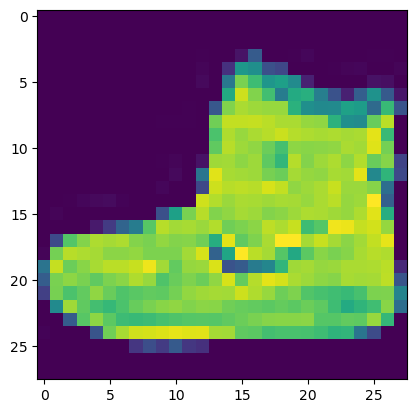

In [288]:
print(f'Train images shape: {x_train.shape}')
print(f'Train labels shape: {t_train.shape}')
print(f'Test images shape: {x_test.shape}')
print(f'Test labels shape: {t_test.shape}')

# Fashion-MNIST 클래스 이름 정의
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 이미지 한 장과 해당 레이블을 선택합니다.
index = 0  # 0번 인덱스를 선택
image = x_train[index][0, :, :]
label = t_train[index]

# 이미지와 레이블을 출력합니다.
plt.imshow(image)
plt.show()

In [279]:
print(train_images[5].shape)
print(train_labels[5])

(1, 28, 28)
2


In [291]:
iters_num = 10000
batch_size = 100
learning_rate = 0.015

# 기울기 최적화 함수들
sgd = SGD()
momentum = Momentum()
adaGrad = AdaGrad()

train_loss_list = []
train_acc_list = []
test_acc_list = []

train_size = x_train.shape[0]
iter_per_epoch = max(train_size / batch_size, 1)

# CNN계층이 적용된 클래스
network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 32, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

verbose = True # 실행되는 과정(손실값, 에폭당 정확도)를 로그로 남길 것인가
current_epoch = 0 # 현재 에폭 수
evaluate_sample_num_per_epoch = None # 모름 옵션인듯


In [290]:
# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

Saved Network Parameters!


In [281]:
print("학습 시작 ~~~~")

for i in range(iters_num):
    
    # 배치 사이즈만큼 랜덤판 데이터를 가져옴
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기를 구함
    grads = network.gradient(x_batch, t_batch)
    
    # 모멘텀 방식으로 기울기 업데이트
    momentum.update(network.params, grads)

    # 현재 손실 함수를 구하고 저장 - 그래프 그리기 위한 데이터
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    #if verbose: print("train loss:" + str(loss))

    # 데이터셋을 한번 학습하면
    if i % iter_per_epoch == 0:
        current_epoch += 1

        x_train_sample, t_train_sample = x_train, t_train
        x_test_sample, t_test_sample = x_test, t_test
        if not evaluate_sample_num_per_epoch is None:
            t = evaluate_sample_num_per_epoch
            x_train_sample, t_train_sample = x_train[:t], t_train[:t]
            x_test_sample, t_test_sample = x_test[:t], t_test[:t]

        # 에폭당 정확도를 구하고 저장 - 그래프 그리기 위한 데이터
        train_acc = network.accuracy(x_train_sample, t_train_sample)
        test_acc = network.accuracy(x_test_sample, t_test_sample)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        # 에폭마다 정확도를 체크
        if verbose: print("=== epoch:" + str(current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")


print("최종 학습률 --> train_acc : %.2f%%, test_acc : %.2f%%" % (train_acc_list[-1]*100, test_acc_list[-1]*100))

학습 시작 ~~~~
=== epoch:1, train acc:0.15571666666666667, test acc:0.156 ===
=== epoch:2, train acc:0.8865166666666666, test acc:0.8711 ===
=== epoch:3, train acc:0.9135666666666666, test acc:0.891 ===
=== epoch:4, train acc:0.92, test acc:0.8954 ===
=== epoch:5, train acc:0.93165, test acc:0.9017 ===
=== epoch:6, train acc:0.9388333333333333, test acc:0.9047 ===
=== epoch:7, train acc:0.9437833333333333, test acc:0.9053 ===
=== epoch:8, train acc:0.94825, test acc:0.9063 ===
=== epoch:9, train acc:0.9546833333333333, test acc:0.9098 ===
=== epoch:10, train acc:0.9543833333333334, test acc:0.9074 ===
=== epoch:11, train acc:0.9589833333333333, test acc:0.9079 ===
=== epoch:12, train acc:0.9595, test acc:0.9084 ===
=== epoch:13, train acc:0.9636333333333333, test acc:0.9115 ===
=== epoch:14, train acc:0.9697833333333333, test acc:0.9102 ===
=== epoch:15, train acc:0.9685166666666667, test acc:0.9107 ===
=== epoch:16, train acc:0.9728333333333333, test acc:0.9124 ===
=== epoch:17, train acc

----

# 학습 그래프

In [282]:
import matplotlib.pyplot as plt
def smooth_curve(x):
    """손실 함수의 그래프를 매끄럽게 하기 위해 사용
    
    참고：http://glowingpython.blogspot.jp/2012/02/convolution-with-numpy.html
    """
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]

### 반복횟수와 손실함수값 추이 (Momentum) ▽

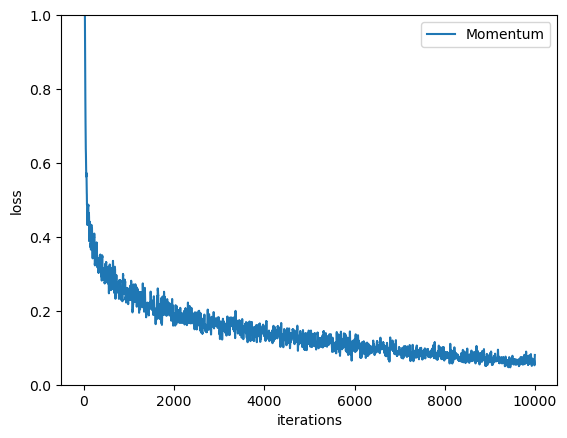

In [283]:
# 손실 함수 값
x = np.arange(len(train_loss_list))
plt.plot(x, smooth_curve(train_loss_list), label='Momentum')
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

### 에폭 당 정확도 변화 ▽

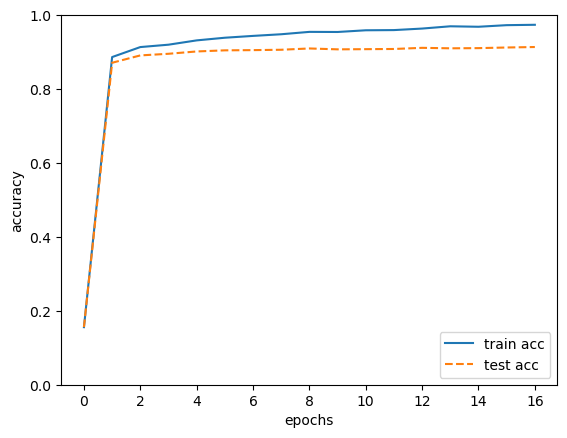

In [284]:
# 에폭 당 정확도
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()